In [1]:
from keras.datasets import cifar100
from __future__ import print_function

import keras.callbacks as cb
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.regularizers import l1, l2
from keras.utils import np_utils

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import time

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

Using TensorFlow backend.


In [0]:
def PreprocessDataset():
    (x_train_org, y_train_org), (x_test_org, y_test_org) = cifar100.load_data(label_mode='fine')
    x_train_org = x_train_org.astype('float32')
    x_test_org = x_test_org.astype('float32')
    # Normalize value to [0, 1]
    #x_train_org /= 255
    #x_test_org /= 255
    # Transform lables to one-hot # for dl, no need to do normalization here because 
    y_train_org = np_utils.to_categorical(y_train_org, 100)
    y_test_org = np_utils.to_categorical(y_test_org, 100)
    # Reshape: here x_train is re-shaped to [width] × [height] x [channel]
    x_train_org = x_train_org.reshape(x_train_org.shape[0], 32, 32, 3) # maybe not needed 
    x_test_org = x_test_org.reshape(x_test_org.shape[0], 32, 32, 3) #maybe not needed because original shape already
    return [x_train_org, x_test_org, y_train_org, y_test_org]

x_train_org, x_test_org, y_train_org, y_test_org = PreprocessDataset()

In [3]:
y_train_org.shape

(50000, 100)

In [0]:
CIFAR100_LABELS_LIST = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

CIFAR100_LABELS_LIST.sort()

In [5]:
label_choosen = ['bridge', 'castle', 'house', 'road', 'skyscraper','cloud', 'forest', 'mountain', 'plain','sea']

label_loc = []
for item in CIFAR100_LABELS_LIST:
  if item in label_choosen:
    print([CIFAR100_LABELS_LIST.index(item), item])
    label_loc.append(CIFAR100_LABELS_LIST.index(item))

[12, 'bridge']
[17, 'castle']
[23, 'cloud']
[33, 'forest']
[37, 'house']
[49, 'mountain']
[60, 'plain']
[68, 'road']
[71, 'sea']
[76, 'skyscraper']


In [0]:
# sub_class selection -- return dictionary (for later milestone 2 usage)
def subclass(x, y):
  x_dict = {}
  y_dict = {}
  for i, item in enumerate(y):
    if np.argmax(item) in label_loc:
      if np.argmax(item) in x_dict.keys():
        x_dict[np.argmax(item)].append(x[i])
        y_dict[np.argmax(item)].append(y[i])
      else:
        x_dict[np.argmax(item)] = []
        x_dict[np.argmax(item)].append(x[i])
        y_dict[np.argmax(item)] = []
        y_dict[np.argmax(item)].append(y[i])
  return x_dict, y_dict

x_train_dict, y_train_dict = subclass(x_train_org, y_train_org)
x_test_dict, y_test_dict = subclass(x_test_org, y_test_org)

In [7]:
y_train_dict[12][0].shape

(100,)

In [8]:
# return np.array
def subclass_np(x_dict, y_dict):
  x = []
  y= []
  for key in x_dict.keys():
    x.append(x_dict[key])
    y.append(y_dict[key])
  x = np.array(x,dtype=np.float32)  
  x = x.reshape(x.shape[0]*x.shape[1], 32,32,3)
  y = np.array(y)
  y =  y.reshape(y.shape[0]*y.shape[1], 100,1)
  print(y.shape)
  return x,y
x_train, y_train_list = subclass_np(x_train_dict, y_train_dict)
x_test,  y_test_list = subclass_np(x_test_dict, y_test_dict)


(5000, 100, 1)
(1000, 100, 1)


In [0]:
# Make y_train_list and y_test_list ready
binary_label_loc_0 = [12,17,37,68,76]
binary_label_0 = ['bridge', 'castle', 'house', 'road', 'skyscraper']
def y_binary(y_list):
  y_bi = []
  for item in y_list:
    if np.argmax(item) in binary_label_loc_0:
      y_bi.append(0)
    else:
      y_bi.append(1)
  return np.array(y_bi)

y_train = y_binary(y_train_list)
y_test = y_binary(y_test_list)
  

In [10]:
print([x_train.shape, y_train.shape, x_test.shape, y_test.shape])
print([np.unique(y_train),np.bincount(y_train)])

[(5000, 32, 32, 3), (5000,), (1000, 32, 32, 3), (1000,)]
[array([0, 1]), array([2500, 2500])]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


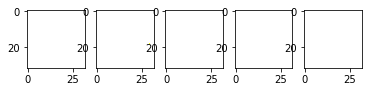

In [11]:
n = 150

for i in range(5):
  n = n+1
  plt.subplot(n)
  plt.imshow(x_train_dict[12][i])

In [12]:
from keras.applications.densenet import DenseNet201,preprocess_input
# create the base pre-trained model
base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(32,32,3))


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
densenet_input_train = preprocess_input(x_train)
densenet_input_test = preprocess_input(x_test)

In [14]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.utils import to_categorical
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- here we have 2 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional DenseNet201 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

print(len(model.layers))

710


In [15]:
# train the model on the new data for a few epochs
model.fit(densenet_input_train, to_categorical(y_train, num_classes=2), batch_size=64, epochs=2,
          validation_data=(densenet_input_test, to_categorical(y_test, num_classes=2)),
          verbose=2, shuffle=True)
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from DenseNet201. We will freeze the bottom N layers
# and train the remaining top layers.

Instructions for updating:
Use tf.cast instead.
Train on 5000 samples, validate on 1000 samples
Epoch 1/2
 - 15s - loss: 0.9086 - acc: 0.6900 - val_loss: 0.6184 - val_acc: 0.7440
Epoch 2/2
 - 3s - loss: 0.5030 - acc: 0.7688 - val_loss: 0.4953 - val_acc: 0.8110


In [16]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 zero_padding2d_1
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_2
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_bn
46 conv2_block6_1_relu
47 conv2_block

In [17]:
# we will freeze the first 7 layers and unfreeze the rest:
for layer in model.layers[:0]:
   layer.trainable = False
for layer in model.layers[0:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.00001, momentum=0.9), loss='binary_crossentropy',metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(densenet_input_train, to_categorical(y_train, num_classes=2), batch_size=64, epochs=150,
          validation_data=(densenet_input_test, to_categorical(y_test, num_classes=2)),
          verbose=2, shuffle=True)

Train on 5000 samples, validate on 1000 samples
Epoch 1/150
 - 47s - loss: 0.4420 - acc: 0.7924 - val_loss: 0.5372 - val_acc: 0.7640
Epoch 2/150
 - 14s - loss: 0.4195 - acc: 0.8104 - val_loss: 0.5125 - val_acc: 0.7750
Epoch 3/150
 - 14s - loss: 0.3878 - acc: 0.8312 - val_loss: 0.5049 - val_acc: 0.7830
Epoch 4/150
 - 15s - loss: 0.3719 - acc: 0.8362 - val_loss: 0.4830 - val_acc: 0.7870
Epoch 5/150
 - 14s - loss: 0.3587 - acc: 0.8424 - val_loss: 0.4664 - val_acc: 0.7860
Epoch 6/150
 - 14s - loss: 0.3350 - acc: 0.8592 - val_loss: 0.4539 - val_acc: 0.7850
Epoch 7/150
 - 14s - loss: 0.3349 - acc: 0.8592 - val_loss: 0.4402 - val_acc: 0.7920
Epoch 8/150
 - 14s - loss: 0.3242 - acc: 0.8614 - val_loss: 0.4341 - val_acc: 0.8060
Epoch 9/150
 - 15s - loss: 0.3095 - acc: 0.8718 - val_loss: 0.4333 - val_acc: 0.8030
Epoch 10/150
 - 14s - loss: 0.3148 - acc: 0.8664 - val_loss: 0.4205 - val_acc: 0.8050
Epoch 11/150
 - 14s - loss: 0.2927 - acc: 0.8788 - val_loss: 0.4121 - val_acc: 0.8170
Epoch 12/150
 -